In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

In [2]:
PATH_DATASET = ''
BATCH_SIZE = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_ds = torchvision.datasets.MNIST(PATH_DATASET, train = True, download = True)
test_ds = torchvision.datasets.MNIST(PATH_DATASET, train = False, download = True )

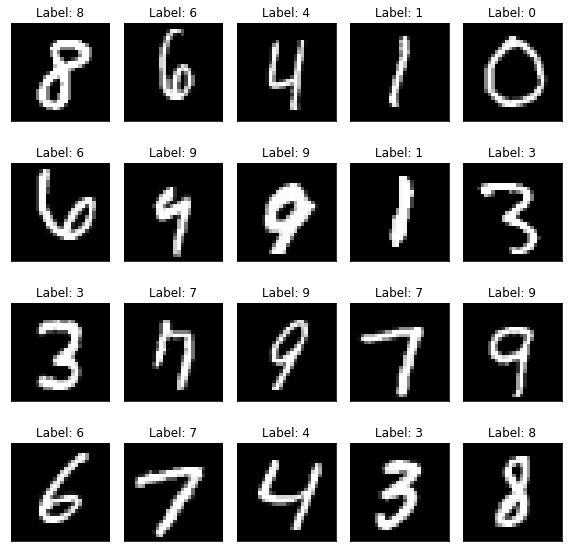

In [4]:
fig, axs = plt.subplots(4, 5, figsize=(8,8))
for ax in axs.flatten():
    # 隨機抽樣
    img, label = random.choice(train_ds)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_ds.transform = transforms.ToTensor()
test_ds.transform = transforms.ToTensor()

# 切割20%訓練資料作為驗證資料
m=len(train_ds) # 總筆數
train_data, val_data = random_split(train_ds, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,shuffle=True)

In [46]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(nn.Conv2d(1, 8, 3, stride = 2, padding = 1),
                                        nn.ReLU(True),
                                        nn.Conv2d(8, 16, 3, stride = 2, padding = 1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(True),
                                        nn.Conv2d(16, 32, 3, stride = 2, padding = 0),
                                        nn.ReLU(True))
        self.flatten = nn.Flatten(start_dim = 1)
        
        self.encoder_lin = nn.Sequential(nn.Linear(3 * 3* 32, 128))
        
        self.encFC1 = nn.Linear(128, encoded_space_dim)
        self.encFC2 = nn.Linear(128, encoded_space_dim)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

In [47]:
def resample(mu, logVar):
    std = torch.exp(logVar / 2)
    eps = torch.randn_like(std)
    return mu + std * eps

In [48]:
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            # 反卷積
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [49]:
torch.manual_seed(0)

d = 4
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128).to(device)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128).to(device)


In [50]:
def loss_fn(out, imgs, mu, logVar):
    kl_divergence = 0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
    return F.binary_cross_entropy(out, imgs, size_average = False) - kl_divergence
lr = 0.001
params_to_optimize = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr = lr)

In [51]:
def add_noise(inputs, noise_factor = 0.3):
    noise = inputs + torch.randn_like(inputs) * noise_factor
    noise = torch.clip(noise, 0, 1)
    return noise

In [56]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor = 0.3):
    
    encoder.train()
    decoder.train()
    train_loss = []
    
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        
        mu, logVar = encoder(image_noisy)
        encoded_data = resample(mu, logVar)
        
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy, mu, logVar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
        
    return np.mean(train_loss)

In [57]:
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn, noise_factor = 0.3):
    
    encoder.eval()
    decoder.eval()
    val_loss = .0
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_noisy = add_noise(image_batch, noise_factor)
            image_noisy = image_noisy.to(device)
            
            mu, logVar = encoder(image_noisy)
            encoded_data = resample(mu, logVar)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            val_loss +=  loss_fn(decoded_data.cpu(), image_batch.cpu(), mu, logVar)
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
    return val_loss.data

In [58]:
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False

def plot_ae_outputs_den(epoch,encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_ds[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(resample(*encoder(image_noisy)))
                              
        if epoch == 0:
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('原圖')
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('加雜訊')
        if epoch == 0: 
            ax = plt.subplot(3, n, i + 1 + n + n)
        else: 
            ax = plt.subplot(1, n, i + 1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if epoch == 0 and i == n//2:
            ax.set_title('重建圖像')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

C:\Users\ian\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


EPOCH 1/50 	 訓練損失：126048.680 	 驗證損失： 3861299.000


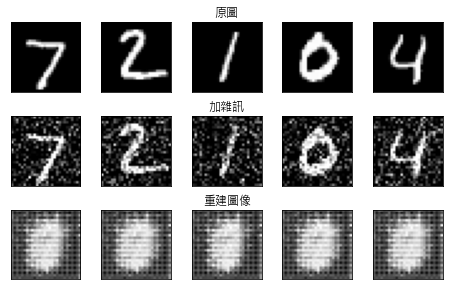

EPOCH 2/50 	 訓練損失：97646.008 	 驗證損失： 2935558.000


<ipython-input-58-67d6fbefdda1>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, n, i + 1)


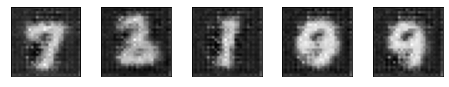

EPOCH 3/50 	 訓練損失：92647.875 	 驗證損失： 2695169.250


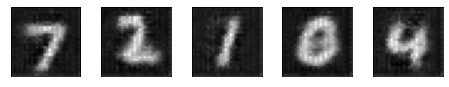

EPOCH 4/50 	 訓練損失：91157.477 	 驗證損失： 2593109.250


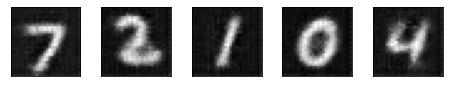

EPOCH 5/50 	 訓練損失：90532.656 	 驗證損失： 2554933.750


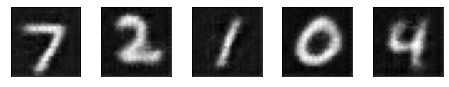

EPOCH 6/50 	 訓練損失：90196.492 	 驗證損失： 2527078.250


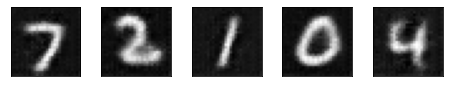

EPOCH 7/50 	 訓練損失：90011.727 	 驗證損失： 2509801.750


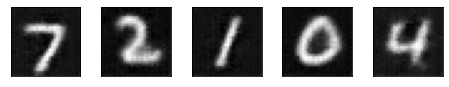

EPOCH 8/50 	 訓練損失：89854.945 	 驗證損失： 2506487.500


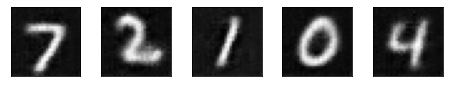

EPOCH 9/50 	 訓練損失：89766.492 	 驗證損失： 2484243.750


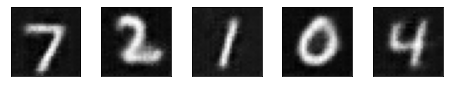

EPOCH 10/50 	 訓練損失：89664.094 	 驗證損失： 2497903.250


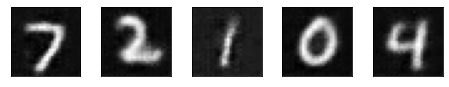

EPOCH 11/50 	 訓練損失：89596.148 	 驗證損失： 2481277.250


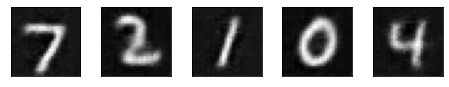

EPOCH 12/50 	 訓練損失：89536.172 	 驗證損失： 2478661.000


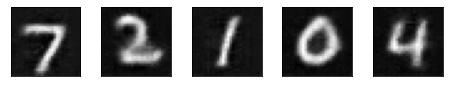

EPOCH 13/50 	 訓練損失：89484.148 	 驗證損失： 2476330.750


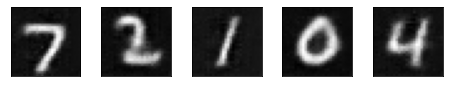

EPOCH 14/50 	 訓練損失：89422.062 	 驗證損失： 2486251.500


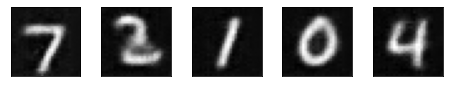

EPOCH 15/50 	 訓練損失：89376.461 	 驗證損失： 2462853.250


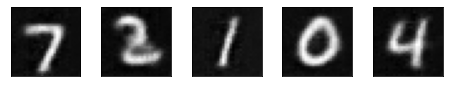

EPOCH 16/50 	 訓練損失：89373.039 	 驗證損失： 2466562.250


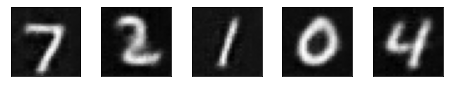

EPOCH 17/50 	 訓練損失：89322.406 	 驗證損失： 2460075.250


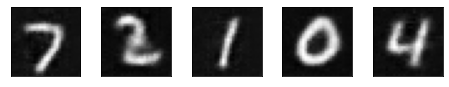

EPOCH 18/50 	 訓練損失：89254.383 	 驗證損失： 2461244.500


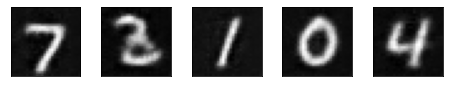

EPOCH 19/50 	 訓練損失：89231.352 	 驗證損失： 2459172.250


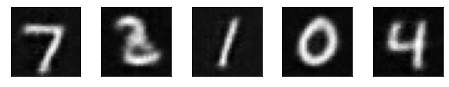

EPOCH 20/50 	 訓練損失：89201.727 	 驗證損失： 2447727.750


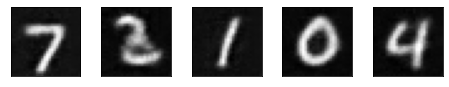

EPOCH 21/50 	 訓練損失：89174.062 	 驗證損失： 2455790.000


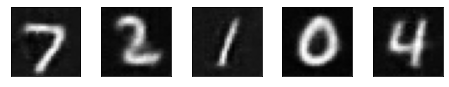

EPOCH 22/50 	 訓練損失：89153.242 	 驗證損失： 2446470.500


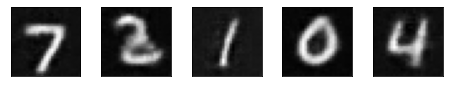

EPOCH 23/50 	 訓練損失：89153.242 	 驗證損失： 2451636.250


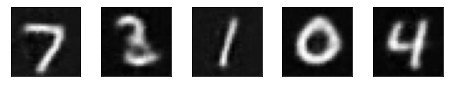

EPOCH 24/50 	 訓練損失：89121.500 	 驗證損失： 2446976.750


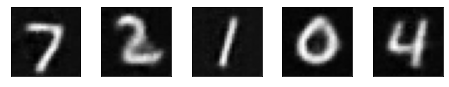

EPOCH 25/50 	 訓練損失：89104.531 	 驗證損失： 2446436.750


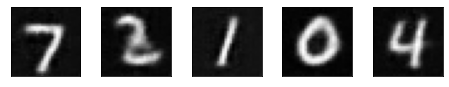

EPOCH 26/50 	 訓練損失：89076.867 	 驗證損失： 2445103.750


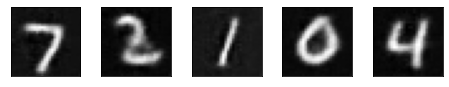

EPOCH 27/50 	 訓練損失：89067.523 	 驗證損失： 2451781.500


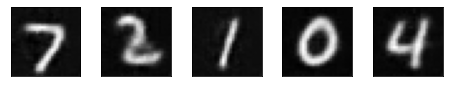

EPOCH 28/50 	 訓練損失：89057.766 	 驗證損失： 2442073.250


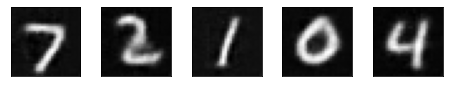

EPOCH 29/50 	 訓練損失：89053.000 	 驗證損失： 2442622.500


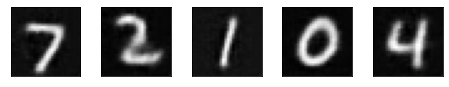

EPOCH 30/50 	 訓練損失：89008.281 	 驗證損失： 2441687.000


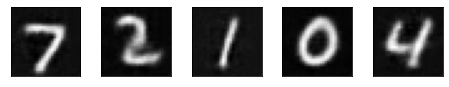

EPOCH 31/50 	 訓練損失：89001.352 	 驗證損失： 2442057.250


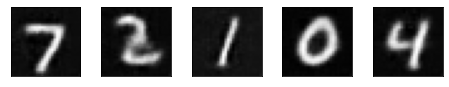

EPOCH 32/50 	 訓練損失：89004.875 	 驗證損失： 2434364.250


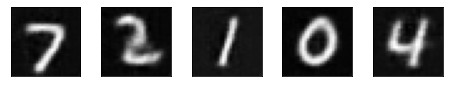

EPOCH 33/50 	 訓練損失：88977.836 	 驗證損失： 2432471.750


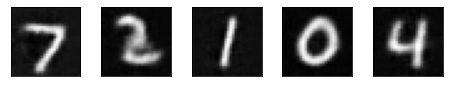

EPOCH 34/50 	 訓練損失：88950.328 	 驗證損失： 2437684.000


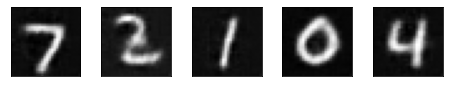

EPOCH 35/50 	 訓練損失：88966.109 	 驗證損失： 2432439.250


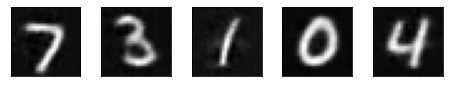

EPOCH 36/50 	 訓練損失：88948.938 	 驗證損失： 2429294.750


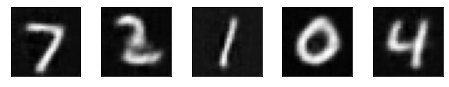

EPOCH 37/50 	 訓練損失：88936.430 	 驗證損失： 2427971.750


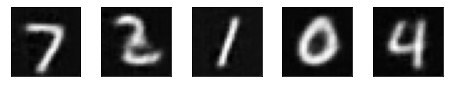

EPOCH 38/50 	 訓練損失：88935.906 	 驗證損失： 2444407.500


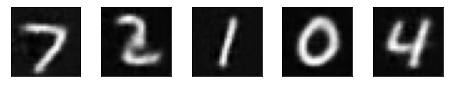

EPOCH 39/50 	 訓練損失：88915.242 	 驗證損失： 2436508.250


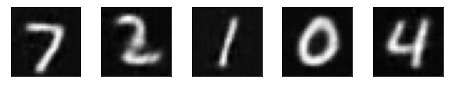

EPOCH 40/50 	 訓練損失：88919.898 	 驗證損失： 2430379.000


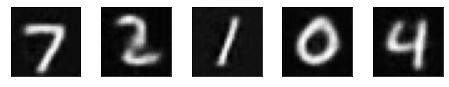

EPOCH 41/50 	 訓練損失：88885.914 	 驗證損失： 2432257.500


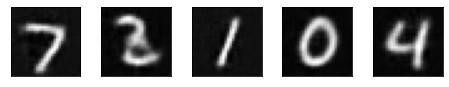

EPOCH 42/50 	 訓練損失：88922.938 	 驗證損失： 2420567.250


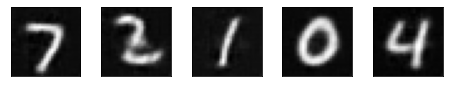

EPOCH 43/50 	 訓練損失：88898.695 	 驗證損失： 2427478.250


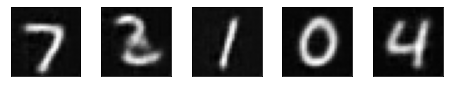

EPOCH 44/50 	 訓練損失：88868.758 	 驗證損失： 2435454.750


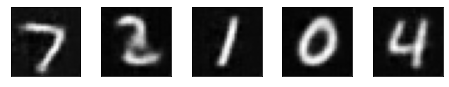

EPOCH 45/50 	 訓練損失：88849.289 	 驗證損失： 2420245.000


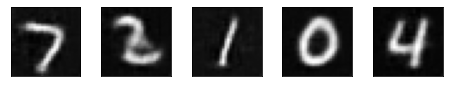

EPOCH 46/50 	 訓練損失：88839.711 	 驗證損失： 2429029.750


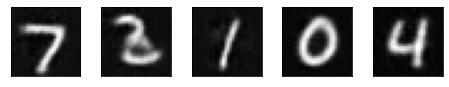

EPOCH 47/50 	 訓練損失：88858.445 	 驗證損失： 2423462.000


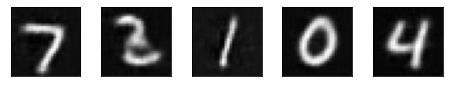

EPOCH 48/50 	 訓練損失：88852.516 	 驗證損失： 2428453.750


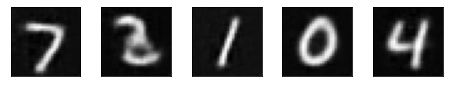

EPOCH 49/50 	 訓練損失：88839.195 	 驗證損失： 2422400.000


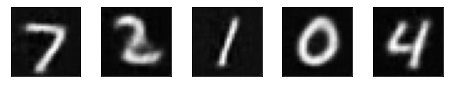

EPOCH 50/50 	 訓練損失：88832.742 	 驗證損失： 2431341.750


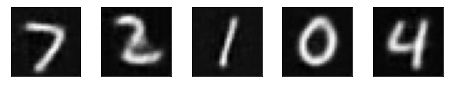

In [59]:
noise_factor = 0.3
num_epochs = 50
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # print(f'EPOCH {epoch + 1}/{num_epochs}')
    # 訓練
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    # 驗證
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validation loss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print(f'EPOCH {epoch + 1}/{num_epochs} \t 訓練損失：{train_loss:.3f}' + 
          f' \t 驗證損失： {val_loss:.3f}')
    plot_ae_outputs_den(epoch,encoder,decoder,noise_factor=noise_factor)

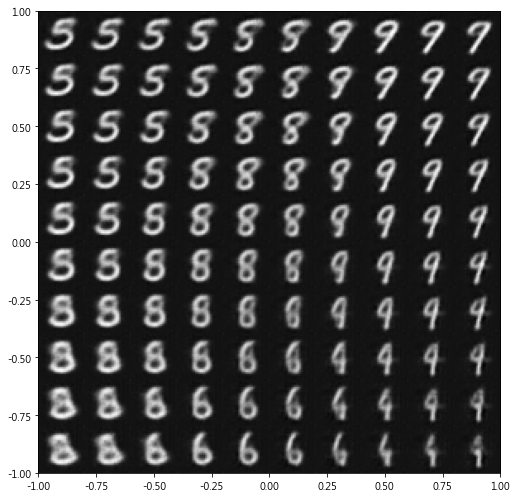

In [60]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    # 隨機亂數
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y], [x, y]]).reshape(-1,4).to(device)
            # print(z.shape)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

In [61]:
encoded_samples = []
for sample in test_ds:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = resample(*encoder(img))
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"變數 {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,變數 0,變數 1,變數 2,變數 3,label
0,0.350380,-0.381316,1.261717,2.492036,7
1,-1.823134,-1.814835,0.145561,-0.661834,2
2,-0.168378,-0.251514,2.458950,-0.763390,1
3,-0.016746,0.216462,-1.337632,-0.714360,0
4,2.216904,-0.307341,-0.563541,0.119799,4
...,...,...,...,...,...
9995,-1.754563,0.274683,-0.134642,-1.031860,2
9996,-1.893307,-0.253309,-0.637543,0.537367,3
9997,1.584810,0.639489,0.915872,0.239089,4
9998,0.665253,1.629042,-0.288122,-0.278001,5


In [62]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(encoded_samples, x='變數 0', y='變數 1', 
                 color=encoded_samples.label.astype(str), opacity=0.7)
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hovertemplate': 'color=7<br>變數 0=%{x}<br>變數 1=%{y}<extra></extra>',
            …

In [63]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# 繪圖
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str)
                 ,labels={'0': 'tsne-變數1', '1': 'tsne-變數2'})
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hovertemplate': 'color=7<br>tsne-變數1=%{x}<br>tsne-變數2=%{y}<extra></extra>',
    …